<a href="https://colab.research.google.com/github/alejandrasuperlano/AlgorithmsUN2021II/blob/main/Lab4/group21_TradingAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ❗❗<font color='red'>ENTRAR AL NOTEBOOK DE COLAB PARA VISUALIZAR LAS GRÁFICAS</font>❗❗

---

In [1]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import datetime
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import download_plotlyjs, plot, iplot, init_notebook_mode
%matplotlib inline

from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError

START_DATE = '2020-10-01 01:00:00'
END_DATE = '2021-11-15 01:00:00'
btc = 'BTC-USD'

# Desde el ultimo de julio hasta el ultimo de octubre
def getData (ticker):
    stockedData = data.DataReader(ticker, 'yahoo', START_DATE, END_DATE)
    return stockedData

In [3]:
tradeData = getData(btc)
tradeData.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-10-01,10915.843750,10493.552734,10785.010742,10623.330078,2.717823e+10,10623.330078
2020-10-02,10662.813477,10440.311523,10624.390625,10585.164062,2.312784e+10,10585.164062
2020-10-03,10614.091797,10527.978516,10583.806641,10565.493164,1.709401e+10,10565.493164
2020-10-04,10700.791016,10531.342773,10567.919922,10684.428711,1.754679e+10,10684.428711
2020-10-05,10804.000977,10646.443359,10688.034180,10804.000977,1.938519e+10,10804.000977


In [4]:
tradeData = tradeData.reindex(index = tradeData.index[::-1])
tradeData.reset_index(inplace = True, drop = True)

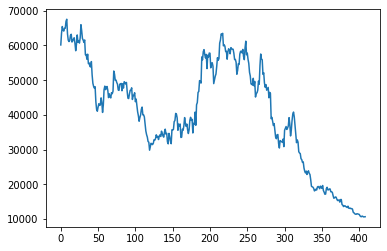

In [5]:
tradeData.Close.plot(kind = 'line')

In [6]:
def sma(df, d):
  c = df.rolling(d).mean()
  return c.dropna()

In [7]:
tradeData['mvSem'] = sma(tradeData.Close, 8)
tradeData['mvMen'] = sma(tradeData.Close, 30)

In [15]:
columns = ['Close', 'mvSem', 'mvMen']

fig = go.Figure()
for column in columns:
  fig.add_trace(go.Scatter(x = tradeData.index, y = tradeData[column], 
                           mode = 'lines', name = column))
  fig.update_layout(template = 'plotly_dark')

iplot(fig)


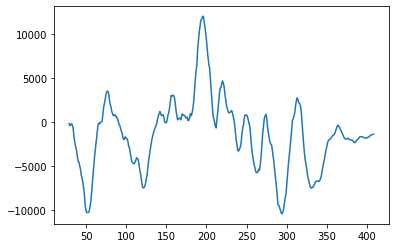

In [9]:
# Restar la media lenta (semanal) de la rapida (mensual)
tradeData['WhenToTrade'] = tradeData['mvSem'] - tradeData['mvMen']
tradeData['WhenToTrade'].plot()

In [10]:
# Positivo = compra, Negativo = venta
tradeData['WhenToTrade_bin'] = tradeData['WhenToTrade'].apply(np.sign)
# tradeData['WhenToTrade_bin'].value_counts()
# shift = desplazar lugares
tradeData['WhenToTrade_long'] = ((tradeData['WhenToTrade_bin'] == 1) & (tradeData['WhenToTrade_bin'].shift(1) == -1) & 
                                 (tradeData['WhenToTrade_bin'].shift(2) == -1) & (tradeData['WhenToTrade_bin'].shift(3) == -1))

tradeData['WhenToTrade_short'] = ((tradeData['WhenToTrade_bin'] == -1) & (tradeData['WhenToTrade_bin'].shift(1) == 1) & 
                                 (tradeData['WhenToTrade_bin'].shift(2) == 1) & (tradeData['WhenToTrade_bin'].shift(3) == 1))

tradeData['WhenToTrade_long'].value_counts()

False    403
True       6
Name: WhenToTrade_long, dtype: int64

In [11]:
tradeData['WhenToTrade_short'].value_counts()

False    402
True       7
Name: WhenToTrade_short, dtype: int64

In [12]:
tradeData['WhenToTrade_buy'] = np.where(tradeData['WhenToTrade_long'] == True, tradeData['mvSem'], np.nan)
tradeData['WhenToTrade_sell'] = np.where(tradeData['WhenToTrade_short'] == True, tradeData['mvSem'], np.nan)

In [13]:
columns = ['mvSem','mvMen','WhenToTrade_buy','WhenToTrade_sell']

fig=go.Figure()
colors = ['#FC92C4', '#B6DB4D','green']
i = 0
for column in columns:
  if column == 'WhenToTrade_buy':
    fig.add_trace(go.Scatter(x=tradeData.index, y=tradeData[column],
                             mode='markers',
                             name='BuyBTC',
                             marker = dict(color='green')
                             ))
  elif column == 'WhenToTrade_sell':
     fig.add_trace(go.Scatter(x=tradeData.index, y=tradeData[column],
                             mode='markers',
                             name= 'Sell BTC',
                             marker = dict(color='magenta')
                             ))
  else:
    fig.add_trace(go.Scatter(x=tradeData.index, y=tradeData[column],
                            mode='lines',
                             name=column,
                             marker=dict(color=colors[i])
                            ))
  i += 1
    
fig.update_layout(template='plotly_dark')


iplot(fig)